# Red MLP

# 1.Configuración e Importación de Librerías

In [15]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models    import Sequential, Model
from tensorflow.keras.layers    import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils     import plot_model

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve,
    accuracy_score, recall_score,
    precision_score, f1_score
)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder
from sklearn.utils           import class_weight as cw

from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings(
    "ignore",
    message="Do not pass an `input_shape`/`input_dim` argument to a layer",
    category=UserWarning
)

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# 2.Carga y División de Datos

In [ ]:
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")
print("Dimensiones del dataset:", df.shape)

# 2.a) Separar X e y
X = df.drop(columns=['incumplimiento_credito'])
y = df['incumplimiento_credito']

# 2.b) Train/Test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Dimensiones del dataset: (78441, 54)
X_train: (62752, 53), X_test: (15689, 53)
y_train: (62752,), y_test: (15689,)


# 3.Preprocesamiento de Datos

In [17]:
categorical_cols = []
dummy_cols       = []
numeric_cols     = []

for col in df.columns:
    if    df[col].dtype == 'object':
        categorical_cols.append(col)
    elif df[col].dtype in ['int64','float64']:
        if df[col].nunique() == 2:
            dummy_cols.append(col)
        else:
            numeric_cols.append(col)

# Quitar la target de las dummies
dummy_cols = [c for c in dummy_cols if c != 'incumplimiento_credito']

print(f"Categóricas ({len(categorical_cols)}):", categorical_cols)
print(f"Dummies     ({len(dummy_cols)}) :", dummy_cols)
print(f"Numéricas   ({len(numeric_cols)}):", numeric_cols)

Categóricas (10): ['numero_hijos', 'acompanantes_solicitud', 'tipo_ingreso', 'nivel_educativo', 'estado_civil', 'tipo_vivienda', 'ocupacion', 'dia_solicitud', 'hora_solicitud', 'tipo_organizacion']
Dummies     (22) : ['tipo_contrato', 'genero', 'posee_auto', 'posee_vivienda', 'telefono_trabajo', 'telefono_personal', 'tiene_email', 'trabaja_fuera_region_registrada', 'vive_fuera_ciudad_registrada', 'trabaja_fuera_ciudad_registrada', 'ciudad_residencia_distinta_trabajo', 'incumplimientos_30_dias', 'default_60_dias_circulo_social', 'dias_ultimo_cambio_telefono', 'documento_3', 'documento_6', 'documento_8', 'consultas_buro_hora', 'consultas_buro_dia', 'consultas_buro_semana', 'consultas_buro_mes', 'consultas_buro_trimestre']
Numéricas   (21): ['ingreso_total', 'cuota_periodica', 'poblacion_relativa_region', 'dias_desde_nacimiento', 'dias_desde_registro', 'dias_desde_emision_id', 'numero_miembros_familia', 'fuente_externa_2', 'fuente_externa_3', 'consultas_buro_anio', 'entradas_buro', 'tipos

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("scale",  StandardScaler(), numeric_cols + dummy_cols),
    ],
    remainder="drop"
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform( X_test )

print("Preprocesamiento completado:")
print(" - X_train_proc shape:", X_train_proc.shape)
print(" - X_test_proc  shape:", X_test_proc.shape)

Preprocesamiento completado:
 - X_train_proc shape: (62752, 90)
 - X_test_proc  shape: (15689, 90)


# 4.Funciones Auxiliares

## 4.1 Registro de Learning Rate

In [19]:
class LRScheduleHistory(Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)

## 4.2 Construcción del MLP

In [20]:
def build_mlp(input_dim, use_bn=True, l2=0.0, dropout_rate=0.3, neurons=[64,32]):
    from tensorflow.keras import regularizers
    model = Sequential()
    model.add(Dense(neurons[0], input_dim=input_dim,
                    activation='relu',
                    kernel_regularizer=regularizers.l2(l2)))
    if use_bn: model.add(BatchNormalization())
    if dropout_rate>0: model.add(Dropout(dropout_rate))
    for n in neurons[1:]:
        model.add(Dense(n, activation='relu',
                        kernel_regularizer=regularizers.l2(l2)))
        if use_bn: model.add(BatchNormalization())
        if dropout_rate>0: model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    return model

## 4.3 Balanceo de Datos

In [21]:
def balance_data(X, y, method):
    if method == "SMOTE":
        return SMOTE(random_state=42).fit_resample(X, y)
    if method == "ADASYN":
        return ADASYN(random_state=42).fit_resample(X, y)
    if method == "class_weight":
        return X, y
    raise ValueError(f"Método de balanceo {method} no reconocido")

## 4.4 Cálculo de Umbral Óptimo (maximizar F1-score)

In [22]:
def optimal_threshold(y_true, y_prob):
    best_thr, best_f1 = 0.5, 0
    for thr in np.linspace(0,1,101):
        f1 = f1_score(y_true, (y_prob>=thr).astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr

# 5.Función de Entrenamiento y Evaluación

In [23]:
def train_and_evaluate(X_tr, y_tr, X_te, y_te,
                       balance_method="SMOTE",
                       optimizer_choice='Adam',
                       lr=1e-3,
                       epochs=50, batch_size=64,
                       use_lr_scheduler=True, patience=5):

    # --- Balanceo con class_weight corregido ---
    if balance_method == "class_weight":
        # No remuestreamos, aplicamos pesos de clase
        Xb, yb = X_tr, y_tr
        classes = np.unique(y_tr)  # array([0, 1])
        cw_vals = cw.compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=y_tr
        )
        class_w = {i: w for i, w in enumerate(cw_vals)}
    else:
        # SMOTE o ADASYN
        Xb, yb = balance_data(X_tr, y_tr, balance_method)
        class_w = None


    # --- Optimizador ---
    opt = {
        'SGD': SGD(lr, momentum=0.9),
        'Adam': Adam(lr),
        'RMSProp': RMSprop(lr, momentum=0.9)
    }[optimizer_choice]

    # --- Construir y compilar modelo ---
    model = build_mlp(input_dim=Xb.shape[1], use_bn=True, l2=1e-4)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # --- Callbacks ---
    lr_hist = LRScheduleHistory()
    cbs = [EarlyStopping('val_loss', patience=patience, restore_best_weights=True),
           lr_hist]
    if use_lr_scheduler:
        cbs.append(ReduceLROnPlateau('val_loss', factor=0.5, patience=3, verbose=1))

    # --- Mostrar arquitectura ---
    model.summary()
    try:
        plot_model(model, to_file='model_architecture.png', show_shapes=True)
        print("Diagrama guardado en 'model_architecture.png'")
    except:
        pass

    # --- Entrenamiento ---
    start = time.time()
    history = model.fit(Xb, yb,
                        validation_data=(X_te, y_te),
                        epochs=epochs, batch_size=batch_size,
                        class_weight=class_w, callbacks=cbs,
                        verbose=1)
    elapsed = time.time() - start

    # --- Predicciones y métricas ---
    y_prob = model.predict(X_te).ravel()
    thr    = optimal_threshold(y_te, y_prob)
    y_pred = (y_prob >= thr).astype(int)

    print("\n=== Reporte de Clasificación ===")
    print(classification_report(y_te, y_pred, zero_division=0))

    # Matriz de confusión
    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"CM: {balance_method}")
    plt.show()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    roc_auc = roc_auc_score(y_te, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0,1], [0,1], 'k--', label='Aleatorio')
    plt.title(f'Curva ROC ({balance_method})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    # --- Evolución del Learning Rate ---
    plt.figure(figsize=(6,4))
    plt.plot(lr_hist.lrs, marker='o')
    plt.title('Learning Rate Evolution')
    plt.xlabel('Época'); plt.ylabel('LR')
    plt.show()

    # Curvas de accuracy y loss
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend(); plt.title('Accuracy vs Epochs'); plt.show()

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend(); plt.title('Loss vs Epochs'); plt.show()

    # Evolución del LR
    plt.plot(lr_hist.lrs, marker='o')
    plt.title('Learning Rate Evolution'); plt.show()

    # Devolver resultados
    return {
        "balance_method": balance_method,
        "optimizer": optimizer_choice,
        "training_time": elapsed,
        "y_pred_prob": y_prob,
        "optimal_threshold": thr,
        "roc_auc": roc_auc_score(y_te, y_prob),
        "metrics": {
            "Precision": precision_score(y_te, y_pred, zero_division=0),
            "Recall":    recall_score(y_te, y_pred, zero_division=0),
            "Accuracy":  accuracy_score(y_te, y_pred),
            "F1-score":  f1_score(y_te, y_pred),
            "AUC":       roc_auc_score(y_te, y_prob)
        }
    }

# 6.Comparación de Técnicas de Balanceo


--- Método de balanceo: SMOTE ---


c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                5824      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 32)               

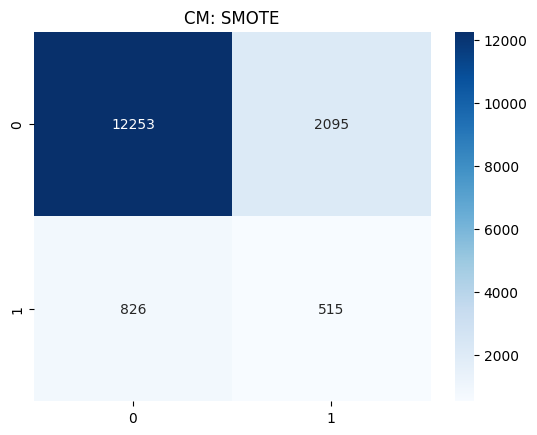

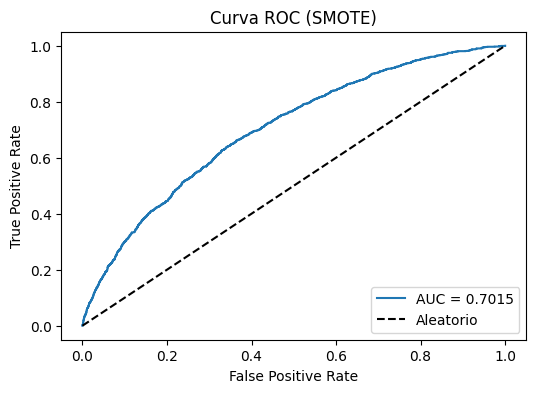

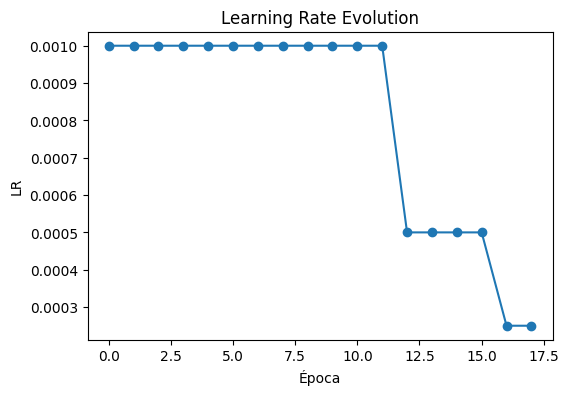

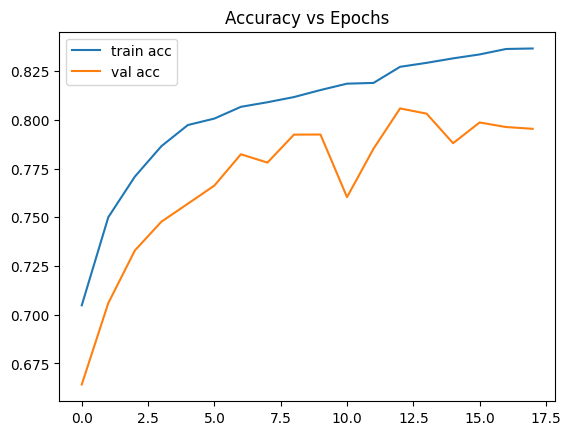

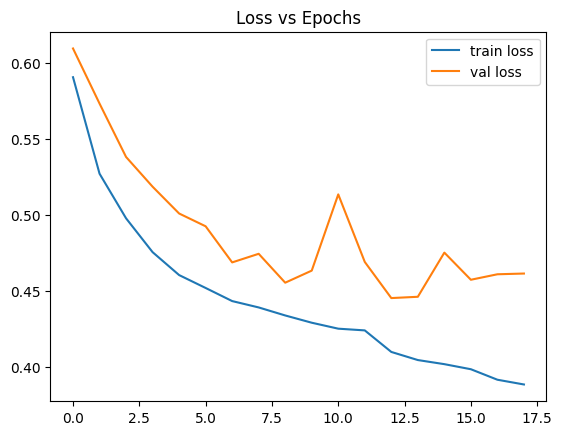

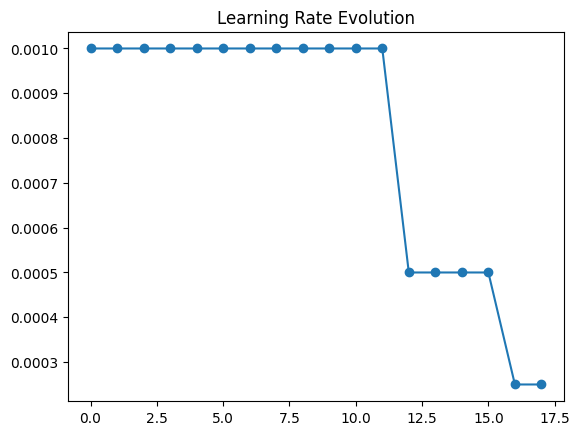


--- Método de balanceo: ADASYN ---


c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                5824      
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 32)               

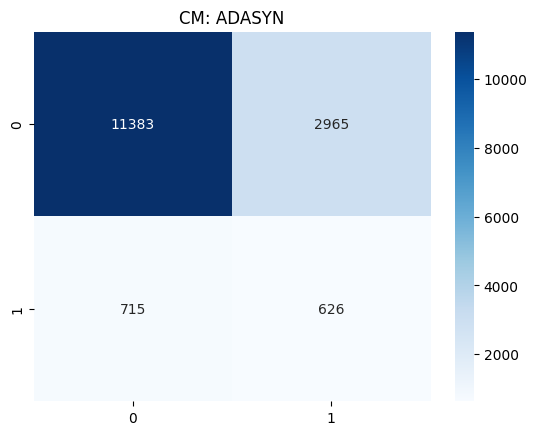

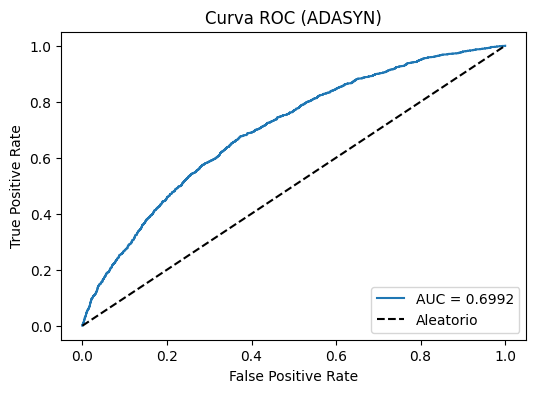

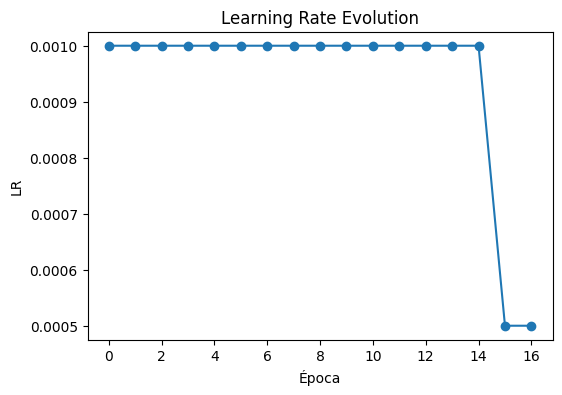

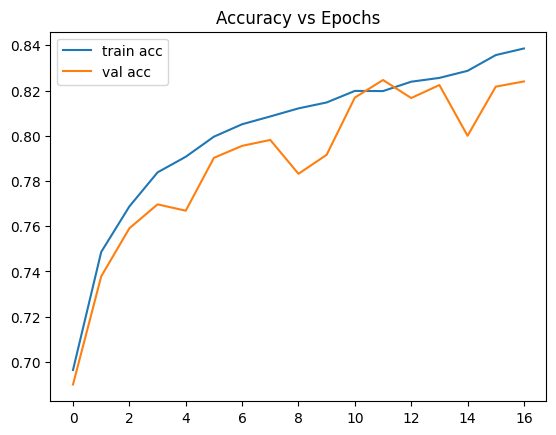

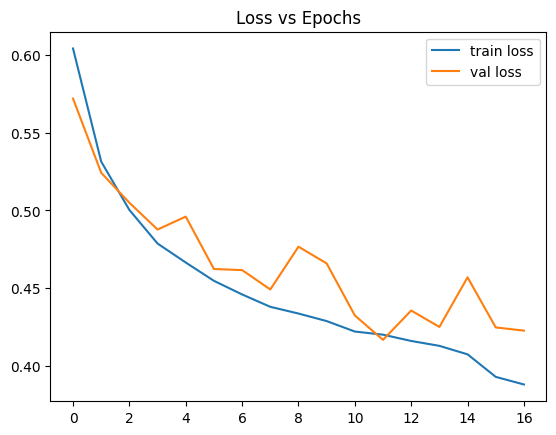

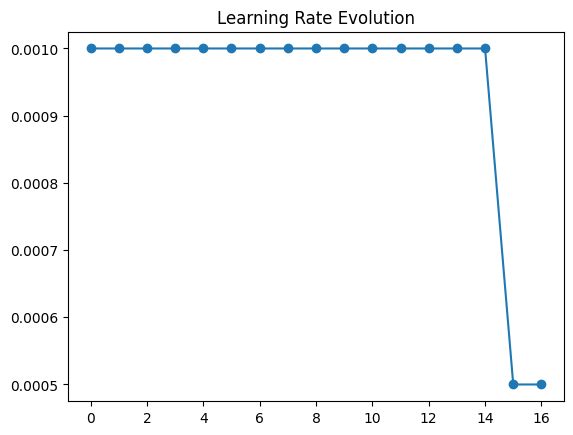


--- Método de balanceo: class_weight ---
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                5824      
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_7 (

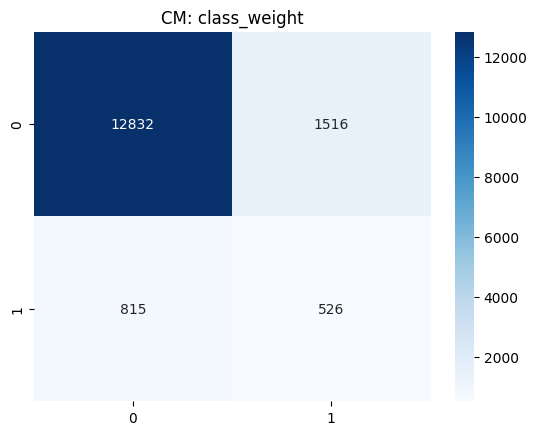

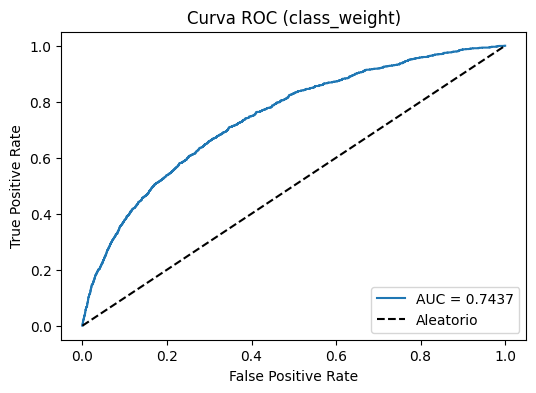

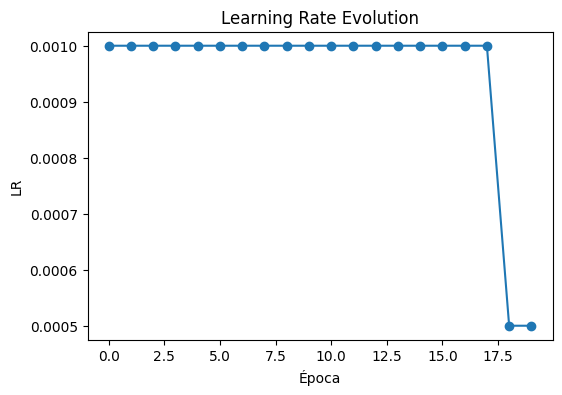

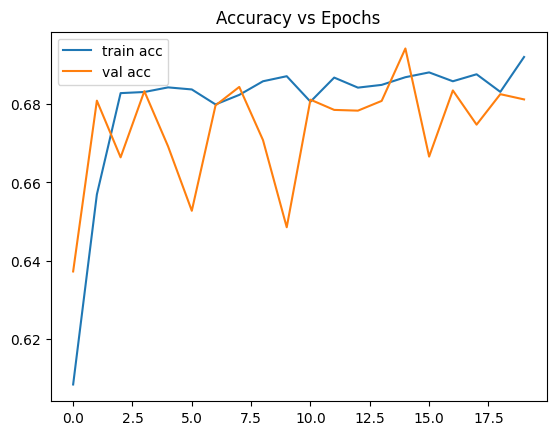

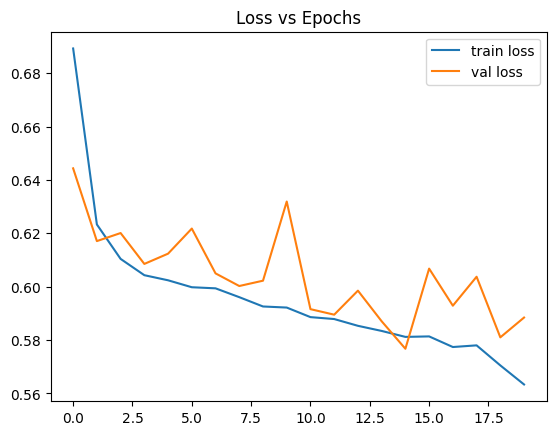

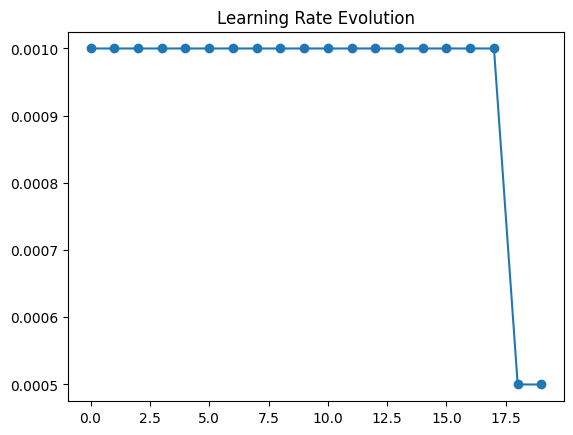

In [24]:
balance_methods = ["SMOTE", "ADASYN", "class_weight"]
results_dict = {}

for method in balance_methods:
    print(f"\n--- Método de balanceo: {method} ---")
    results_dict[method] = train_and_evaluate(
        X_train_proc, y_train, X_test_proc, y_test,
        balance_method=method,
        optimizer_choice="Adam",
        lr=1e-3,
        epochs=50,
        batch_size=64,
        use_lr_scheduler=True,
        patience=5
    )


In [25]:
import tensorflow as tf
print("Dispositivos físicos:", tf.config.list_physical_devices('GPU'))


Dispositivos físicos: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("CUDA version:", tf.sysconfig.get_build_info()["cuda_version"])
print("cuDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])


TensorFlow version: 2.10.1
CUDA version: 64_112
cuDNN version: 64_8


# 7.Visualización de Resultados y Comparación de Umbrales

In [27]:
# 7.a) Crear tabla de métricas
table_data = []
for method, res in results_dict.items():
    y_pred = (res["y_pred_prob"] >= res["optimal_threshold"]).astype(int)
    table_data.append({
        "Método":     method,
        "Precision":  precision_score(y_test, y_pred, zero_division=0),
        "Recall":     recall_score(   y_test, y_pred, zero_division=0),
        "Accuracy":   accuracy_score(y_test, y_pred),
        "F1-score":   f1_score(      y_test, y_pred, zero_division=0),
        "AUC":        res["roc_auc"],
        "Tiempo (s)": res["training_time"]
    })

df_metrics = pd.DataFrame(table_data).set_index("Método")


===== Resumen de Métricas por Método de Balanceo =====


,Precision,Recall,Accuracy,F1-score,AUC,Tiempo (s)
Método,,,,,,
SMOTE,0.1973,0.3840,0.8138,0.2607,0.7015,104.06
ADASYN,0.1743,0.4668,0.7654,0.2539,0.6992,96.90
class_weight,0.2576,0.3922,0.8514,0.3110,0.7437,66.10


c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

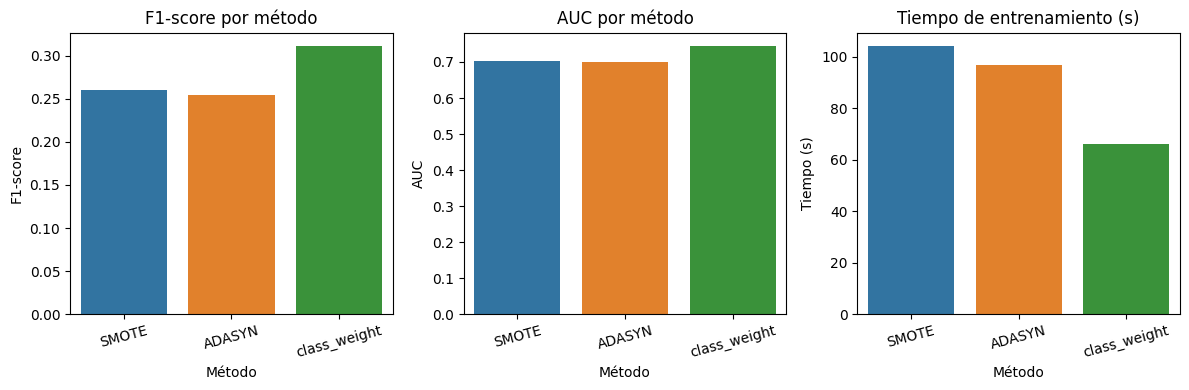

In [28]:
# 7.b) Imprimir la tabla
print("\n===== Resumen de Métricas por Método de Balanceo =====")
display(df_metrics.style.format({
    "Precision":  "{:.4f}",
    "Recall":     "{:.4f}",
    "Accuracy":   "{:.4f}",
    "F1-score":   "{:.4f}",
    "AUC":        "{:.4f}",
    "Tiempo (s)": "{:.2f}"
}))

# 7.c) Graficar comparación de F1, AUC y Tiempo
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.barplot(x=df_metrics.index, y="F1-score", data=df_metrics.reset_index())
plt.title("F1-score por método")
plt.xticks(rotation=15)

plt.subplot(1,3,2)
sns.barplot(x=df_metrics.index, y="AUC", data=df_metrics.reset_index())
plt.title("AUC por método")
plt.xticks(rotation=15)

plt.subplot(1,3,3)
sns.barplot(x=df_metrics.index, y="Tiempo (s)", data=df_metrics.reset_index())
plt.title("Tiempo de entrenamiento (s)")
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


In [29]:

# 7.d) VISUALIZAR Y APLICAR EL UMBRAL ÓPTIMO

for method, res in results_dict.items():
    thr = res["optimal_threshold"]
    print(f"Umbral óptimo para {method}: {thr:.3f}")

    # Predecir con el umbral por defecto 0.5
    y_pred_default = (res["y_pred_prob"] >= 0.5).astype(int)
    acc_def = accuracy_score(y_test, y_pred_default)

    # Predecir con el umbral óptimo
    y_pred_opt = (res["y_pred_prob"] >= thr).astype(int)
    acc_opt = accuracy_score(y_test, y_pred_opt)

    print(f"  Accuracy @ 0.50: {acc_def:.4f}")
    print(f"  Accuracy @ {thr:.2f}: {acc_opt:.4f}\n")


Umbral óptimo para SMOTE: 0.520
  Accuracy @ 0.50: 0.8059
  Accuracy @ 0.52: 0.8138

Umbral óptimo para ADASYN: 0.370
  Accuracy @ 0.50: 0.8247
  Accuracy @ 0.37: 0.7654

Umbral óptimo para class_weight: 0.690
  Accuracy @ 0.50: 0.6942
  Accuracy @ 0.69: 0.8514



In [30]:
# 7.e. COMPARAR MÉTRICAS @ UMBRALES 0.5 VS ÓPTIMO
# Construimos la tabla
rows = []
for method, res in results_dict.items():
    y_prob = res["y_pred_prob"]
    thr    = res["optimal_threshold"]

    # Predicciones con umbral 0.5
    y_def = (y_prob >= 0.5).astype(int)
    prec_def = precision_score(y_test, y_def, zero_division=0)
    rec_def  = recall_score(   y_test, y_def, zero_division=0)
    f1_def   = f1_score(      y_test, y_def, zero_division=0)
    acc_def  = accuracy_score(y_test, y_def)

    # Predicciones con umbral óptimo
    y_opt = (y_prob >= thr).astype(int)
    prec_opt = precision_score(y_test, y_opt, zero_division=0)
    rec_opt  = recall_score(   y_test, y_opt, zero_division=0)
    f1_opt   = f1_score(      y_test, y_opt, zero_division=0)
    acc_opt  = accuracy_score(y_test, y_opt)

    rows.append({
        "Método":       method,
        "Umbral":       "0.50",
        "Precision":    f"{prec_def:.4f}",
        "Recall":       f"{rec_def:.4f}",
        "F1-score":     f"{f1_def:.4f}",
        "Accuracy":     f"{acc_def:.4f}"
    })
    rows.append({
        "Método":       method,
        "Umbral":       f"{thr:.2f}",
        "Precision":    f"{prec_opt:.4f}",
        "Recall":       f"{rec_opt:.4f}",
        "F1-score":     f"{f1_opt:.4f}",
        "Accuracy":     f"{acc_opt:.4f}"
    })

df_thresholds = pd.DataFrame(rows)

# Mostramos la tabla ordenada por método y umbral
print("\n===== Métricas @ Umbrales =====")
print(df_thresholds.sort_values(["Método","Umbral"]).to_string(index=False))



===== Métricas @ Umbrales =====
      Método Umbral Precision Recall F1-score Accuracy
      ADASYN   0.37    0.1743 0.4668   0.2539   0.7654
      ADASYN   0.50    0.1924 0.3289   0.2428   0.8247
       SMOTE   0.50    0.1930 0.3997   0.2603   0.8059
       SMOTE   0.52    0.1973 0.3840   0.2607   0.8138
class_weight   0.50    0.1694 0.6607   0.2697   0.6942
class_weight   0.69    0.2576 0.3922   0.3110   0.8514


# 8.Guardar Resultados

In [31]:
# Guardar la tabla resumen de métricas en un archivo CSV
df_metrics.to_csv("resultados_metricas.csv", index=False)
print("Tabla de métricas guardada en 'resultados_metricas.csv'")

# Guardar el diccionario de resultados (results_dict) usando pickle
import pickle
with open("results_dict.pkl", "wb") as f:
    pickle.dump(results_dict, f)
print("Diccionario de resultados guardado en 'results_dict.pkl'")


Tabla de métricas guardada en 'resultados_metricas.csv'
Diccionario de resultados guardado en 'results_dict.pkl'


In [32]:
import os
print("📁 Carpeta actual:", os.getcwd())


📁 Carpeta actual: c:\Users\DELL\AppData\Local\Programs\Microsoft VS Code
